In [ ]:
# # Google Colab Specific commands
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/pravin_thesis/0_dataset/11_balanced_class_subfolder_no_label.zip" -d '/content/dataset/'

replace /content/dataset/cocci/cocci.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
!pip install keras_cv

In [4]:
mkdir 'models'

mkdir: cannot create directory ‘models’: File exists


In [5]:
# Copy the models
!cp -r '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/7_ensemble_avg_3_models_and_3_split/individual_model/efficientnetV2B2_best_model.h5' -d './models'
!cp -r '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/7_ensemble_avg_3_models_and_3_split/individual_model/mobilenet_best_model.h5' -d './models'
!cp -r '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/7_ensemble_avg_3_models_and_3_split/individual_model/nasnetmobile_best_model.h5' -d './models'

In [6]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average, Resizing
from keras.optimizers import AdamW
import keras_cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger
import os
import numpy as np
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [7]:
# Define the custom objects
# Define the custom objects for loading models
custom_objects_1 = {
    'EfficientNetV2Backbone': keras_cv.models.EfficientNetV2Backbone,
    'ImageClassifier': keras_cv.models.ImageClassifier,
    'AdamW': AdamW
}
model_1 = load_model('./models/efficientnetV2B2_best_model.h5', custom_objects=custom_objects_1, compile=False)

optimizer = keras.optimizers.AdamW(learning_rate = 0.0001)
model_1.compile(optimizer = optimizer,
                  loss = keras.losses.SparseCategoricalCrossentropy(),
                  metrics = ["accuracy"])

model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='efficientnetV2B2')

In [ ]:
# Define the custom objects
custom_objects_2 = {
    'MobileNetV3Backbone': keras_cv.models.MobileNetV3Backbone,
    'ImageClassifier': keras_cv.models.ImageClassifier,
    'AdamW': AdamW
}
model_2 = load_model('./models/mobilenet_best_model.h5', custom_objects=custom_objects_2,  compile=False)
optimizer = keras.optimizers.AdamW(learning_rate = 0.0001)
model_2.compile(optimizer = optimizer,
                  loss = keras.losses.SparseCategoricalCrossentropy(),
                  metrics = ["accuracy"])
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='mobileNetV3')

In [9]:
# # Define the custom objects
# custom_objects_3 = {
#     'AdamW': AdamW
# }
# model_3 = load_model('./models/nasnetmobile_best_model.h5', custom_objects=custom_objects_3, compile=False)
# # optimizer = keras.optimizers.AdamW(learning_rate = 0.0001)
# # model_3.compile(optimizer = optimizer,
# #                   loss = keras.losses.SparseCategoricalCrossentropy(),
# #                   metrics = ["accuracy"])

# # model_3 = Model(inputs=model_3.inputs,
# #                 outputs=model_3.outputs,
# #                 name='nasnetmobile')

In [10]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_nasnetmobile_model():
    pre_model = NASNetMobile(input_shape=(224, 224, 3),
                             include_top=False,
                             weights='imagenet',
                             pooling='avg')
    pre_model.trainable = True

    inputs = pre_model.input
    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='NasnetMobile')
    return model

# Create model instance
model_3 = create_nasnetmobile_model()

# Load weights
try:
    model_3.load_weights('./models/nasnetmobile_best_model.h5')
    print("Weights loaded successfully.")
except Exception as e:
    print(f"Error loading weights: {e}")

# Compile model (if needed)
model_3.compile(optimizer=Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])


Weights loaded successfully.


In [ ]:
# Freeze the layers of the pre-trained models
# for model in [model_1, model_2,model_3]:
for model in [model_1, model_2]:
    for layer in model.layers:
        layer.trainable = False

In [ ]:
# Define the input layer with a common shape
common_input_shape = (224, 224, 3)  # Chosen common input shape
model_input = Input(shape=common_input_shape)

# Resize inputs to match model_1's required input shape
resize_input_1 = Resizing(260, 260)(model_input)
output_1 = model_1(resize_input_1)

# Resize inputs to match model_2's required input shape
resize_input_2 = Resizing(224, 224)(model_input)
output_2 = model_2(resize_input_2)

# Resize inputs to match model_3's required input shape
# resize_input_3 = Resizing(224, 224)(model_input)
# output_3 = model_3(resize_input_3)

In [ ]:
# Ensure output_1 output_2 and output_3 are tensors with the same shape
print(f'output_1 shape: {output_1[0].shape}')
print(f'output_2 shape: {output_2[0].shape}')
# print(f'output_2 shape: {output_3.shape}')

In [14]:
# Average the outputs to create the ensemble output
# ensemble_output = Average()([output_1[0], output_2[0], output_3])
ensemble_output = Average()([output_1[0], output_2[0]])

In [15]:
# Create the ensemble model
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [16]:
# Compile the ensemble model
ensemble_model.compile(optimizer=AdamW(learning_rate=0.0001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [17]:
ensemble_model.summary()

Model: "ensemble"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resizing (Resizing)       │ (None, 260, 260, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resizing_1 (Resizing)     │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetV2B2          │ (None, 4)              │      8,775,010 │ resizing[0][0]         │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobileNetV3 (Functional)  │ (None, 4)              │      3,000,196 │ resizing_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average (Average)         │ (None, 4)              │              0 │ efficientnetV2B2[0][0… │
│                           │                        │                │ mobileNetV3[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,775,206 (44.92 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 11,775,206 (44.92 MB)

In [18]:
# Directory containing subfolders of each class with images
data_dir = './dataset'

In [19]:
filepath =[]
label = []

folds = os.listdir(data_dir)

for fold in folds:
    f_path = os.path.join(data_dir , fold)

    imgs = os.listdir(f_path)

    for img in imgs:

        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_complete = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [20]:
df_complete

,filepath,label
0,./dataset/cocci/cocci.2456.jpg,cocci
1,./dataset/cocci/cocci.1352.jpg,cocci
2,./dataset/cocci/cocci.624.jpg,cocci
3,./dataset/cocci/cocci.965.jpg,cocci
4,./dataset/cocci/cocci.1109.jpg,cocci
...,...,...
11235,./dataset/salmo/salmo.42.jpg,salmo
11236,./dataset/salmo/salmo.1751.jpg,salmo
11237,./dataset/salmo/salmo.2503.jpg,salmo
11238,./dataset/salmo/salmo.127.jpg,salmo


In [21]:
# Spliting in train_val and test
train_val_df , test_df = train_test_split(df_complete ,train_size = 0.9 ,random_state = 4224, stratify=df_complete['label'])
# Spliting in train and val
train_df , val_df = train_test_split(train_val_df ,train_size = 0.8 ,random_state = 4224, stratify=train_val_df['label'])

In [22]:
# Shape
print(f"The shape of The Train data is: {train_df.shape}")
print(f"The shape of The Validation data is: {val_df.shape}")
print(f"The shape of The Test data is: {test_df.shape}")

The shape of The Train data is: (8092, 2)
The shape of The Validation data is: (2024, 2)
The shape of The Test data is: (1124, 2)


In [23]:
def plot_images_from_df(df, title):
    classes = df['label'].unique()
    fig, axs = plt.subplots(len(classes), 5, figsize=(15, len(classes) * 3))
    fig.suptitle(title, fontsize=16)

    for i, cls in enumerate(classes):
        # Filter images of the current class
        cls_images = df[df['label'] == cls]
        # Randomly select 5 images
        selected_images = cls_images.sample(n=5, random_state=4224).reset_index()

        for j in range(5):
            img_path = selected_images.loc[j, 'filepath']  # Assuming the dataframe has a 'filepath' column
            img = plt.imread(img_path)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            # Display the class label and image path as the title
            axs[i, j].set_title(f'Class: {cls}\nPath: {img_path}', fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot images for train, validation, and test dataframes
plot_images_from_df(train_df, 'Train Dataset')
plot_images_from_df(val_df, 'Validation Dataset')
plot_images_from_df(test_df, 'Test Dataset')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Count the occurrences of each category in the 'category' column
count = train_df['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
BATCH_SIZE=32

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Flow images from dataframes and apply augmentation (if any)
print("Training Data")
train_ds = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    # Shuffle is default True, and used in training data
    class_mode='sparse'
)

print("Validation Data")
validation_ds = validation_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    # Shuffle is default True, not used in validation
    shuffle=False,
    # class_mode='categorical',
    class_mode='sparse'
)

print("Test Data")
test_ds = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    # Shuffle is default True, not used in test
    shuffle=False,
    # class_mode='categorical',
    class_mode='sparse'
)

In [30]:
# Get the class indices assigned by the generators
class_indices_train = train_ds.class_indices

# Print the class indices
print("Class indices for Training Data:", class_indices_train)

Class indices for Training Data: {'cocci': 0, 'healthy': 1, 'ncd': 2, 'salmo': 3}


In [31]:
# Count occurrences of each class in training data
train_class_counts = Counter(train_ds.classes)
print("Training class distribution:", train_class_counts)

# Count occurrences of each class in validation data
val_class_counts = Counter(validation_ds.classes)
print("Validation class distribution:", val_class_counts)

# Count occurrences of each class in test data
test_class_counts = Counter(test_ds.classes)
print("Validation class distribution:", test_class_counts)

Training class distribution: Counter({1: 2023, 3: 2023, 2: 2023, 0: 2023})
Validation class distribution: Counter({1: 506, 0: 506, 3: 506, 2: 506})
Validation class distribution: Counter({3: 281, 2: 281, 1: 281, 0: 281})


In [32]:
# Define the model save path
model_save_path = 'ensemble_freezed_layer.keras'

# # Delete the file if it exists
# if os.path.exists(model_save_path):
#     try:
#         os.remove(model_save_path)
#         print(f"Existing '{model_save_path}' file deleted.")
#     except OSError as e:
#         print(f"Error deleting file: {e}")
#         # Handle the error, maybe ask the user to close any program using the file

# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1, save_weights_only=False),
    CSVLogger('training_freezed_layer.csv', append=True)
]

steps_per_epoch=train_ds.samples // train_ds.batch_size
validation_steps=validation_ds.samples // validation_ds.batch_size

# Train the ensemble model
history = ensemble_model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_ds,
    validation_steps=validation_steps,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9596 - loss: 0.1099
Epoch 1: val_loss improved from inf to 0.08685, saving model to ensemble_freezed_layer.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 117s 329ms/step - accuracy: 0.9596 - loss: 0.1099 - val_accuracy: 0.9673 - val_loss: 0.0869 - learning_rate: 1.0000e-04
Epoch 2/30
  1/252 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.9688 - loss: 0.1220

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.08685 to 0.01961, saving model to ensemble_freezed_layer.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9688 - loss: 0.1220 - val_accuracy: 1.0000 - val_loss: 0.0196 - learning_rate: 1.0000e-04
Epoch 3/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9630 - loss: 0.1024
Epoch 3: val_loss did not improve from 0.01961
252/252 ━━━━━━━━━━━━━━━━━━━━ 47s 181ms/step - accuracy: 0.9630 - loss: 0.1024 - val_accuracy: 0.9673 - val_loss: 0.0869 - learning_rate: 1.0000e-04
Epoch 4/30
  1/252 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.9375 - loss: 0.1075
Epoch 4: val_loss did not improve from 0.01961
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.9375 - loss: 0.1075 - val_accuracy: 1.0000 - val_loss: 0.0196 - learning_rate: 1.0000e-04
Epoch 5/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9660 - loss: 0.1008
Epoch 5: val_loss did not improve from 0.01961
252/252 ━━━━━━━━━━━━━━━━━━━━ 49s 191ms/step - accuracy:

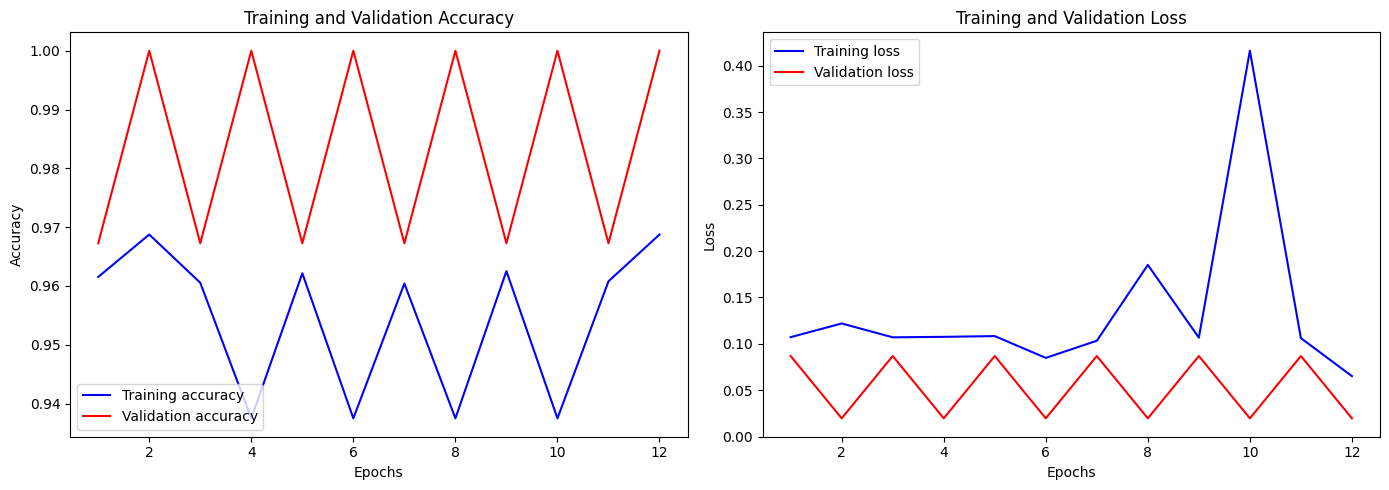

In [33]:
# TODO: Plot the training and test loss curve - for 30 epochs
# Extract accuracy and loss data from history

# Plot history from csv
import pandas as pd
import matplotlib.pyplot as plt

# Load the training history from CSV
# history.history = pd.read_csv('training_log_10_epoch.csv')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the number of epochs
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
# Import trained model and log csv from drive
!cp '/content/ensemble_freezed_layer.keras' '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/7_ensemble_avg_3_models_and_3_split/4_output_freezed_ensemble/'
!cp '/content/training_freezed_layer.csv' '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/7_ensemble_avg_3_models_and_3_split/4_output_freezed_ensemble/'

In [ ]:
# Import trained model and log csv from drive
!cp -r '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/5_ensemble/4_output_freezed_ensemble/ensemble_freezed_layer.keras' -d '.'
!cp -r '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/5_ensemble/4_output_freezed_ensemble/training_freezed_layer.csv' -d '.'

In [37]:
# Define the model save path
model_save_path = 'ensemble_freezed_layer.keras'

# Local Model
# loaded_model = ensemble_model

# Load the model
loaded_model = load_model(model_save_path)


# Verify the model structure and summary
loaded_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 958 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "ensemble"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resizing (Resizing)       │ (None, 260, 260, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resizing_1 (Resizing)     │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetV2B2          │ (None, 4)              │      8,775,010 │ resizing[0][0]         │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobileNetV3 (Functional)  │ (None, 4)              │      3,000,196 │ resizing_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average (Average)         │ (None, 4)              │              0 │ efficientnetV2B2[0][0… │
│                           │                        │                │ mobileNetV3[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 35,093,284 (133.87 MB)

 Trainable params: 11,659,038 (44.48 MB)

 Non-trainable params: 116,168 (453.78 KB)

 Optimizer params: 23,318,078 (88.95 MB)

In [ ]:
# # Manual Predict label
# def load_and_preprocess_image(image_path, target_size=(224, 224)):
#     # Load the image
#     img = load_img(image_path, target_size=target_size)
#     # Convert the image to an array
#     img_array = img_to_array(img)
#     # Expand dimensions to match the expected input shape for the model
#     img_array = np.expand_dims(img_array, axis=0)
#     # Normalize the image array
#     img_array /= 255.0
#     return img_array

# # Example usage
# image_class = 'healthy'
# image_number = '10'
# image_path = f'./dataset/{image_class}/{image_class}.{image_number}.jpg'
# preprocessed_image = load_and_preprocess_image(image_path)

# # Predict

# # Make a prediction
# predictions = loaded_model.predict(preprocessed_image)
# predicted_class = np.argmax(predictions, axis=1)

# # Optionally, map the predicted class to the class label
# class_labels = list(train_generator.class_indices.keys())
# predicted_label = class_labels[predicted_class[0]]

# print(f'Predicted class: {predicted_class[0]}')
# print(f'Predicted label: {predicted_label}')

1/1 [==============================] - 0s 32ms/step
Predicted class: 1
Predicted label: healthy


In [38]:
# Evaluate the ensemble model - Validation Data
eval_results = loaded_model.evaluate(validation_ds, steps=validation_ds.samples // validation_ds.batch_size)
print(f'Validation loss: {eval_results[0]}')
print(f'Validation accuracy: {eval_results[1]}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.9688 - loss: 0.0849
Validation loss: 0.08685164898633957
Validation accuracy: 0.9672619104385376


In [39]:
# Confusion Matrix - Validation Data
# Make predictions on validation data
validation_ds.reset()
predictions = ensemble_model.predict(validation_ds, steps=validation_ds.samples // validation_ds.batch_size, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = validation_ds.classes[:len(predicted_classes)]
class_labels = list(validation_ds.class_indices.keys())

# Calculate metrics
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')
conf_matrix = confusion_matrix(true_classes, predicted_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step
Precision: 0.9678250877926681
Recall: 0.9672619047619048
F1-score: 0.9673318798450186
Confusion Matrix:
 [[500   3   1   0]
 [ 15 480   0   8]
 [  6  16 482   0]
 [  2  13   2 488]]


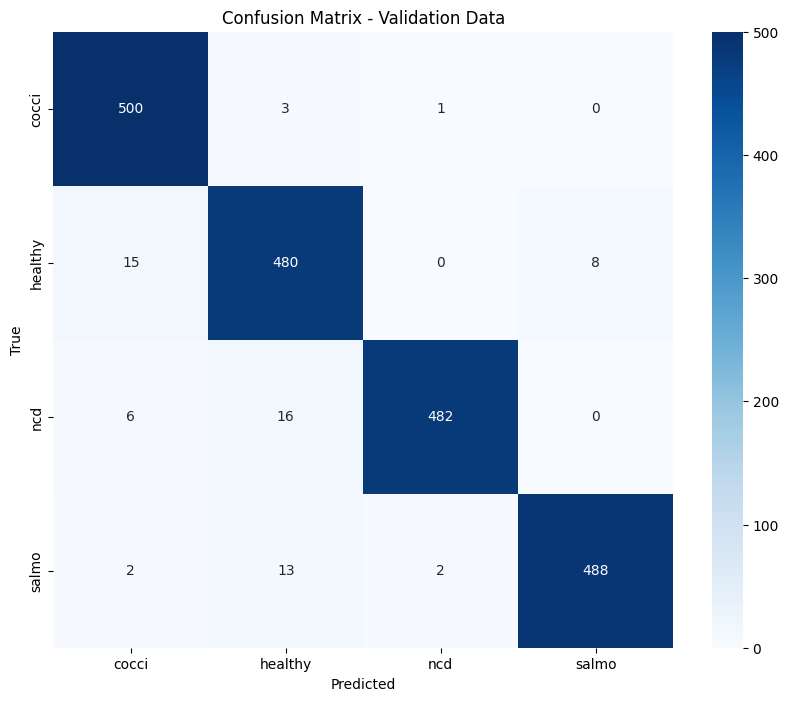

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_ds.class_indices.keys(), yticklabels=validation_ds.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Data')
plt.show()


In [41]:
# Evaluate the ensemble model - Test Data
eval_results = loaded_model.evaluate(test_ds, steps=test_ds.samples // test_ds.batch_size)
print(f'Test loss: {eval_results[0]}')
print(f'Test accuracy: {eval_results[1]}')

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9688 - loss: 0.0972
Test loss: 0.11405696719884872
Test accuracy: 0.9651785492897034


In [42]:
# Confusion Matrix - Test Data
# Make predictions on test data
test_ds.reset()
predictions = ensemble_model.predict(test_ds, steps=test_ds.samples // test_ds.batch_size, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_ds.classes[:len(predicted_classes)]
class_labels = list(test_ds.class_indices.keys())

# Calculate metrics
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')
conf_matrix = confusion_matrix(true_classes, predicted_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step
Precision: 0.9661791318250087
Recall: 0.9651785714285714
F1-score: 0.9653428389080115
Confusion Matrix:
 [[279   2   0   0]
 [  9 266   0   4]
 [  3  11 266   0]
 [  0  10   0 270]]


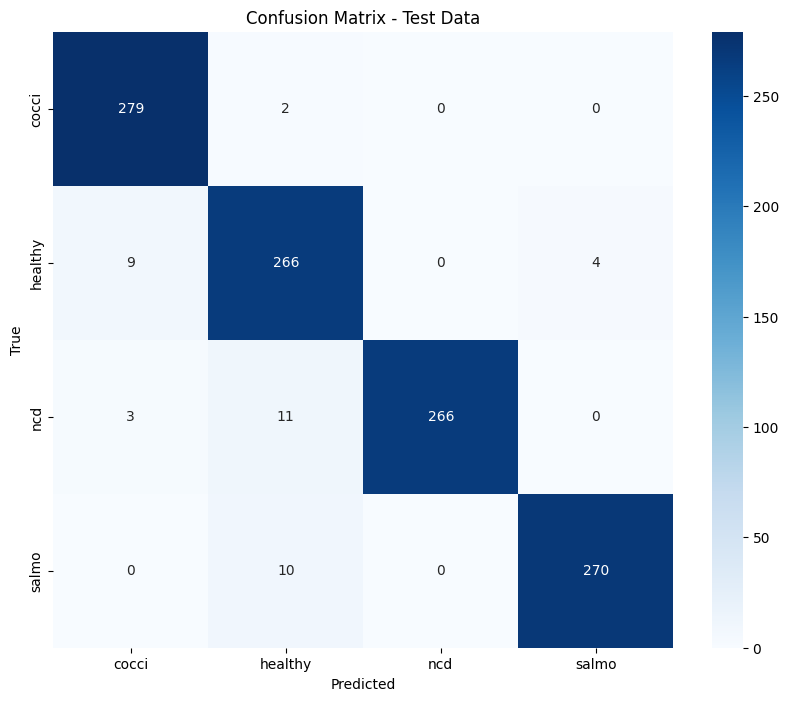

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.class_indices.keys(), yticklabels=test_ds.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Data')
plt.show()
